In [1]:
from gensim import corpora, models
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

If not making any changes, ignore when rerunning script

In [7]:
#get a list of filtered tokens by removing named entities
# Load the processed corpus from the .pkl file
with open("../../Acts/processed_acts.pkl", "rb") as f:
    processed_acts = pickle.load(f)

with open("../../unique_named_entities.pkl", "rb") as f:
    unique_named_entities = pickle.load(f)

acts_filtered_token_lists = [
    [token for token in tragedy["tokens"] if token.lower() not in unique_named_entities]
    for tragedy in processed_acts
]


In [8]:
#Ignore if making changes
pickle.dump(acts_filtered_token_lists, open('acts_filtered_token_lists.pkl', 'wb'))

In [9]:
# Step 1: Create dictionary and BoW corpus from processed tokens

# Create a dictionary from the tokenized texts
acts_filtered_dictionary = corpora.Dictionary(acts_filtered_token_lists)

# Filter out extreme tokens
acts_filtered_dictionary.filter_extremes(no_below=2, no_above=0.5) #no_below=2 removes words that appear in fewer than 2 acts #no_above=0.5 removes words that appear in more than 50% of the acts

# Create a bag-of-words representation of the corpus
acts_filtered_corpus = [acts_filtered_dictionary.doc2bow(tokens) for tokens in acts_filtered_token_lists]

In [10]:
#Ignore if making changes
pickle.dump(acts_filtered_corpus, open('acts_filtered_corpus.pkl', 'wb'))
acts_filtered_dictionary.save('acts_filtered_dictionary.gensim')

In [6]:
num_topics = list(range(5,26)) # Tests 5 to 25 topics 
num_keywords = 10

acts_filtered_LDA_models = {}
acts_filtered_LDA_topics = {}
for i in num_topics:
    acts_filtered_LDA_models[i] = LdaModel(corpus=acts_filtered_corpus,
                             id2word=acts_filtered_dictionary,
                             num_topics=i,
                             chunksize=len(acts_filtered_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = acts_filtered_LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False) #returns a list of (topic_id, topic_words) pairs
    acts_filtered_LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics] #topic[1] is a list of (word, probability) tuples for the given topic #word[0] is the word in topic[1], word[1] would be the probability 

In [ ]:
for i, topic_words in enumerate(acts_filtered_LDA_topics[5]): # just to see the topics for the 5-topic model
    print(f"Topic {i+1}: {', '.join(topic_words)}")
#each key is number of topics in the corresponding LDA model 
#so key 5 is LDA model with 5 topics
#Each value is a list of topics, and each topic is a list of the top num_keywords (here, 10) words for that topic
#Each inner list is one topic’s top words

Topic 1: uis, orbis, rego, tyrannus, imperium, ratis, princeps, decet, superbus, timor
Topic 2: eripio, aufero, pietas, dextera, uerbum, perago, puer, sedeo, uiuo, pes
Topic 3: astrum, sentio, ara, nemus, polus, orbis, monstrum, currus, geminus, iratus
Topic 4: ratis, grex, fretum, regius, uentus, classis, spes, iuuo, certus, dominus
Topic 5: sono, uis, monstrum, sidus, adsum, uotum, sceptrum, uerbum, noceo, nemus


In [ ]:
#Ignore if making changes
pickle.dump(acts_filtered_LDA_models, open('acts_filtered_LDA_models.pkl', 'wb'))
pickle.dump(acts_filtered_LDA_topics, open('acts_filtered_LDA_topics.pkl', 'wb'))

In [14]:
#write a function to derive the Jaccard similarity of two topics

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - where: 
    - A∩B is the number of common elements between sets
    - A∪B is the total number of unique elements in both sets.
    - In set theory, the intersection (written using the symbol "∩" between the terms) 
    - of two sets A and B, denoted by A∩B, is the set containing all elements of A that also belong to B
    - or equivalently, all elements of B that also belong to A.
    
    The value of Jaccard similarity ranges from 0 to 1:
    - J(A,B)=1 → The sets are identical.
    - J(A,B)=0 → The sets have no common elements.
    
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [ ]:
# Derive mean stability across topics by comparing the next topic model
acts_LDA_stability = {}

for i in range(len(num_topics) - 1): #excluding the last topic count because otherwise I will run into LDA_topic[26+1] not in range error
    jaccard_sims = []
    for topic1 in acts_filtered_LDA_topics[num_topics[i]]: #LDA_topic[1] would give one topic
        sims = []
        for topic2 in acts_filtered_LDA_topics[num_topics[i + 1]]:
            sims.append(jaccard_similarity(topic1, topic2))  #inner loop compares topic1 with each topic in the 2-topic model; i.e. LDA_topic[4] would compare each topic against LDA_topic[5], which has 5 topics
        jaccard_sims.append(sims)
    
    acts_LDA_stability[num_topics[i]] = jaccard_sims

acts_filtered_mean_stabilities = [np.array(acts_LDA_stability[i]).mean() for i in num_topics[:-1]] #list of average Jaccard similarities comparing each model with the next one — lower values mean more diversity


#another way of writing it since num_topics[0] = LDA_topics[1] 
#for i in num_topics[:-1]:  # values like 1, 2, ..., 9 #excluding the last topic count because otherwise I will run into LDA_topic[10+1] not in range error
    #jaccard_sims = []
    #for topic1 in filtered_LDA_topics[i]:
        #sims = []
        #for topic2 in filtered_LDA_topics[i + 1]:
            #sims.append(jaccard_similarity(topic1, topic2))
        #jaccard_sims.append(sims)
    
    #filtered_LDA_stability[i] = jaccard_sims

In [17]:
#get topic coherences
acts_filtered_coherences = [CoherenceModel(model=acts_filtered_LDA_models[i], texts=acts_filtered_token_lists, dictionary=acts_filtered_dictionary, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [ ]:
#Ignore if making changes
pickle.dump(acts_filtered_coherences, open('acts_filtered_coherences.pkl', 'wb'))
pickle.dump(acts_filtered_mean_stabilities, open('acts_filtered_mean_stabilities.pkl', 'wb'))

In [21]:
# derive the ideal number of topics by finding the topic count where the difference between topic coherence and topic stability is largest — i.e., where a model is both semantically coherent and sufficiently diverse
acts_filtered_coh_sta_diffs = [                            
    acts_filtered_coherences[i] - acts_filtered_mean_stabilities[i]        # iterate over the indices of coherences (which we know is length 9 because mean_stabilities is length 9)
    for i in range(len(acts_filtered_coherences))
]
acts_filtered_coh_sta_max = max(acts_filtered_coh_sta_diffs) # max() returns the item with the highest value # candidate for the "best" topic model: high coherence, low redundancy
acts_filtered_coh_sta_max_idxs = [i for i, j in enumerate(acts_filtered_coh_sta_diffs) if j == acts_filtered_coh_sta_max] # multiple topics counts could have the same best score #collect all indices i where the score equals the maximum
acts_filtered_ideal_topic_num_index = acts_filtered_coh_sta_max_idxs[0] # Choose the first index among the best-scoring ones — i.e., the lowest topic number in case of ties
acts_filtered_ideal_topic_num = num_topics[acts_filtered_ideal_topic_num_index] # use that index to look up the actual topic count

In [ ]:
#Ignore if making changes
pickle.dump(acts_filtered_coh_sta_diffs, open('acts_filtered_coh_sta_diffs.pkl', 'wb'))
pickle.dump(acts_filtered_coh_sta_max, open('acts_filtered_coh_sta_max.pkl', 'wb'))
pickle.dump(acts_filtered_coh_sta_max_idxs, open('acts_filtered_coh_sta_max_idxs.pkl', 'wb'))
pickle.dump(acts_filtered_ideal_topic_num_index, open('acts_filtered_ideal_topic_num_index.pkl', 'wb'))
pickle.dump(acts_filtered_ideal_topic_num, open('acts_filtered_ideal_topic_num.pkl', 'wb'))

In [25]:
print(f"Ideal topic number (filtered tokens): {acts_filtered_ideal_topic_num}")

Ideal topic number (filtered tokens): 24


In [29]:
# Get indices of top five coherence–stability tradeoff scores
top5_indices = sorted(range(len(acts_filtered_coh_sta_diffs)), key=lambda i: acts_filtered_coh_sta_diffs[i], reverse=True)[:5]

print("Top 5 ideal topic numbers (filtered tokens):")
for idx in top5_indices:
    topic_num = num_topics[idx]
    score = acts_filtered_coh_sta_diffs[idx]
    print(f"Topic number: {topic_num} (Δ coherence–stability: {score:.4f})")

Top 5 ideal topic numbers (filtered tokens):
Topic number: 24 (Δ coherence–stability: 0.2573)
Topic number: 21 (Δ coherence–stability: 0.2542)
Topic number: 9 (Δ coherence–stability: 0.2535)
Topic number: 22 (Δ coherence–stability: 0.2462)
Topic number: 17 (Δ coherence–stability: 0.2379)


Use to rerun script (ignore if making changes)

In [ ]:
with open("./acts_filtered_token_lists.pkl", "rb") as f:
    acts_filtered_token_lists = pickle.load(f)

with open('acts_filtered_corpus.pkl', 'rb') as f:
	acts_filtered_corpus = pickle.load(f)
acts_filtered_dictionary = corpora.Dictionary.load('acts_filtered_dictionary.gensim')

with open('acts_filtered_LDA_models.pkl', 'rb') as f:
    acts_filtered_LDA_models = pickle.load(f)

with open('acts_filtered_LDA_topics.pkl', 'rb') as f:
    acts_filtered_LDA_topics = pickle.load(f)

with open('acts_filtered_coherences.pkl', 'rb') as f:
    acts_filtered_coherences = pickle.load(f)

with open('acts_filtered_mean_stabilities.pkl', 'rb') as f:
    acts_filtered_mean_stabilities = pickle.load(f)

with open('acts_filtered_coh_sta_diffs.pkl', 'rb') as f:
    acts_filtered_coh_sta_diffs = pickle.load(f)

with open('acts_filtered_coh_sta_max.pkl', 'rb') as f:
    acts_filtered_coh_sta_max = pickle.load(f)

with open('acts_filtered_coh_sta_max_idxs.pkl', 'rb') as f:
    acts_filtered_coh_sta_max_idxs = pickle.load(f)

with open('acts_filtered_ideal_topic_num_index.pkl', 'rb') as f:
    acts_filtered_ideal_topic_num_index = pickle.load(f)

with open('acts_filtered_ideal_topic_num.pkl', 'rb') as f:
    acts_filtered_ideal_topic_num = pickle.load(f)

## Line Graph Showing the Ideal Number of Topics with Filtered Tokens

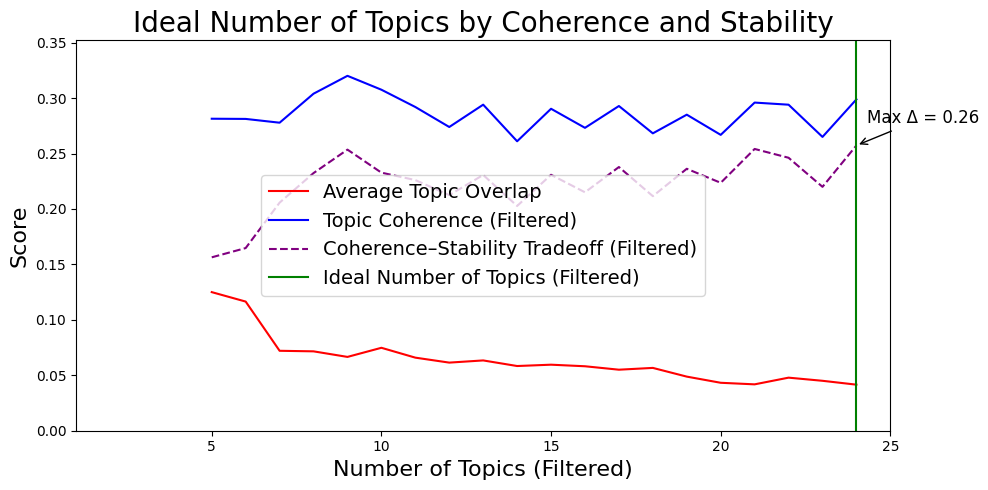

In [30]:
#graph these metrics across the topic numbers
topic_range = num_topics[:-1]  # [5, 6, ..., 24]
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=topic_range, y=acts_filtered_mean_stabilities, label='Average Topic Overlap', color='red')
ax = sns.lineplot(x=topic_range, y=acts_filtered_coherences, label='Topic Coherence (Filtered)', color='blue')
ax = sns.lineplot(x=topic_range, y=acts_filtered_coh_sta_diffs, label='Coherence–Stability Tradeoff (Filtered)', color='purple', linestyle='--')

# Vertical line for ideal topic number
ax.axvline(x=acts_filtered_ideal_topic_num, label='Ideal Number of Topics (Filtered)', color='green', linestyle='-')

# Dynamic Y-axis scaling
y_max = max(max(acts_filtered_coherences), max(acts_filtered_mean_stabilities), max(acts_filtered_coh_sta_diffs)) * 1.1
ax.set_ylim([0, y_max])

# X-axis from 1 to 10 (inclusive)
ax.set_xlim([1, num_topics[-1]])

peak_index = topic_range.index(acts_filtered_ideal_topic_num)
peak_x = topic_range[peak_index]
peak_y = acts_filtered_coh_sta_diffs[peak_index]

ax.annotate(f'Max Δ = {peak_y:.2f}',
            xy=(peak_x, peak_y),
            xytext=(peak_x + 0.3, peak_y + 0.02),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=12,
            color='black')


# Labels and title
ax.set_title('Ideal Number of Topics by Coherence and Stability', fontsize=20)
ax.set_ylabel('Score', fontsize=16)
ax.set_xlabel('Number of Topics (Filtered)', fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("../figures/acts_filtered_topics_coherence_stability.png", dpi=300)  # Save the figure
plt.show()

## Using PyLDAvis for Filtered Tokens

### Top Topic Words for Filtered Tokens

In [33]:
# Get the ideal model based on earlier calculation
acts_filtered_model = acts_filtered_LDA_models[acts_filtered_ideal_topic_num]

# Print top topic words
print(f"\nTop {num_keywords} words per topic for filtered LDA({acts_filtered_ideal_topic_num}):\n")

for topic_id, topic_words in acts_filtered_model.show_topics(num_topics=acts_filtered_ideal_topic_num, num_words=num_keywords, formatted=False):
    words_only = [word for word, prob in topic_words]
    print(f"Topic {topic_id + 1}: {', '.join(words_only)}")


Top 10 words per topic for filtered LDA(24):

Topic 1: princeps, misero, inuideo, ratis, soror, pietas, demens, similis, funestus, uis
Topic 2: orbis, dexter, horridus, uiuo, gnatus, moror, pario, uirgo, debeo, socer
Topic 3: currus, nefandus, facinus, geminus, fluctus, curro, sentio, natura, fessus, puer
Topic 4: ratis, grex, pelagus, fretum, sors, classis, for, uotum, dominus, regius
Topic 5: nurus, amo, bruma, altrix, diligo, opto, scindo, par, neo, bonus
Topic 6: tergus, squamosus, coherceo, deuius, proludo, praetempto, uomo, refundo, fluctus, dominus
Topic 7: orbis, uis, armo, opprimo, diuus, astrum, sanctus, pudor, exprimo, humanus
Topic 8: astrum, orbis, sono, nemus, uirtus, horridus, gemo, uoltus, polus, nouerca
Topic 9: sentio, nobilis, ortus, spolium, linquo, monstrum, inferus, horridus, canis, ultimus
Topic 10: uotum, fletus, uastus, gena, excipio, cinis, fluctus, recipio, nex, pondus
Topic 11: paternus, aufero, pietas, imperium, nefandus, facinus, scio, quies, bonus, opus


In [19]:
for idx, topic in sorted(acts_filtered_model.print_topics(num_words=10)):
    print(f"Topic #{idx + 1}: {topic}")

Topic #3: 0.010*"currus" + 0.005*"nefandus" + 0.005*"facinus" + 0.005*"geminus" + 0.005*"fluctus" + 0.005*"curro" + 0.005*"sentio" + 0.005*"natura" + 0.005*"fessus" + 0.005*"puer"
Topic #4: 0.012*"ratis" + 0.009*"grex" + 0.007*"pelagus" + 0.006*"fretum" + 0.006*"sors" + 0.006*"classis" + 0.006*"for" + 0.005*"uotum" + 0.005*"dominus" + 0.005*"regius"
Topic #6: 0.010*"tergus" + 0.010*"squamosus" + 0.010*"coherceo" + 0.010*"deuius" + 0.010*"proludo" + 0.010*"praetempto" + 0.000*"uomo" + 0.000*"refundo" + 0.000*"fluctus" + 0.000*"dominus"
Topic #7: 0.013*"orbis" + 0.011*"uis" + 0.008*"armo" + 0.008*"opprimo" + 0.007*"diuus" + 0.006*"astrum" + 0.006*"sanctus" + 0.006*"pudor" + 0.006*"exprimo" + 0.006*"humanus"
Topic #8: 0.011*"astrum" + 0.007*"orbis" + 0.006*"sono" + 0.006*"nemus" + 0.006*"uirtus" + 0.006*"horridus" + 0.005*"gemo" + 0.005*"uoltus" + 0.005*"polus" + 0.005*"nouerca"
Topic #9: 0.023*"sentio" + 0.010*"nobilis" + 0.010*"ortus" + 0.010*"spolium" + 0.010*"linquo" + 0.005*"monstrum

In [36]:
acts_filtered_document_topics = []
for i, bow in enumerate(acts_filtered_corpus):
    topic_dist = acts_filtered_model.get_document_topics(bow)  # topic_dist is a list of tuples representing the topic distribution for the i-th document # each tuple is (topic_id, topic_weight)
    acts_filtered_document_topics.append((processed_acts[i]["id"], topic_dist))

for title, topics in acts_filtered_document_topics:
    # Get topic with highest probability
    top_topic = max(topics, key=lambda x: x[1])
    print(f"{title:<20} → Filtered Topic #{top_topic[0] + 1} (weight: {top_topic[1]:.3f})")
   
#get topic distribution for each play
for title, topics in acts_filtered_document_topics:
    print(f"\n{title}")
    top_three = sorted(topics, key=lambda x: -x[1])[:3]
    for topic_id, weight in top_three:
        print(f"  Filtered Topic #{topic_id + 1}: {weight:.3f}")

seneca-agamemnon_act1 → Filtered Topic #11 (weight: 0.997)
seneca-agamemnon_act2 → Filtered Topic #12 (weight: 0.996)
seneca-agamemnon_act3 → Filtered Topic #12 (weight: 0.604)
seneca-agamemnon_act4 → Filtered Topic #9 (weight: 0.995)
seneca-agamemnon_act5 → Filtered Topic #13 (weight: 0.998)
seneca-hercules-furens_act1 → Filtered Topic #12 (weight: 0.679)
seneca-hercules-furens_act2 → Filtered Topic #12 (weight: 0.510)
seneca-hercules-furens_act3 → Filtered Topic #12 (weight: 0.968)
seneca-hercules-furens_act4 → Filtered Topic #10 (weight: 0.577)
seneca-hercules-furens_act5 → Filtered Topic #8 (weight: 0.998)
seneca-hercules-oetaeus_act1 → Filtered Topic #8 (weight: 0.998)
seneca-hercules-oetaeus_act2 → Filtered Topic #12 (weight: 0.502)
seneca-hercules-oetaeus_act3 → Filtered Topic #8 (weight: 0.508)
seneca-hercules-oetaeus_act4 → Filtered Topic #8 (weight: 0.888)
seneca-hercules-oetaeus_act5 → Filtered Topic #8 (weight: 0.999)
seneca-medea_act1    → Filtered Topic #2 (weight: 0.979)

In [37]:
# Show topic distribution for all Ecerinis acts
for title, topics in acts_filtered_document_topics:
    if "ecerinis" in title:
        print(f"\n{title}")
        top_three = sorted(topics, key=lambda x: -x[1])[:3]
        for topic_id, weight in top_three:
            print(f"  Filtered Topic #{topic_id + 1}: {weight:.3f}")


mussato-ecerinis_act1
  Filtered Topic #11: 0.922
  Filtered Topic #4: 0.076

mussato-ecerinis_act2
  Filtered Topic #19: 0.997

mussato-ecerinis_act3
  Filtered Topic #12: 0.827
  Filtered Topic #19: 0.166

mussato-ecerinis_act4
  Filtered Topic #4: 0.996

mussato-ecerinis_act5
  Filtered Topic #19: 0.997


In [ ]:
#Find all tragedy acts most associated with each Ecerinis act's top topics 

# Show topic distribution for all Ecerinis acts
for title, topics in acts_filtered_document_topics:
    if "ecerinis" in title:
        print(f"\n{title}")
        top_three = sorted(topics, key=lambda x: -x[1])[:3]
        for topic_id, weight in top_three:
            print(f"  Filtered Topic #{topic_id + 1}: {weight:.3f}")
            # Find all acts (excluding this Ecerinis act) most associated with this topic
            matching_acts = []
            for act, ts in acts_filtered_document_topics:
                if act != title:
                    for tid, weight in ts:
                        if tid == topic_id:
                            matching_acts.append((act, weight))
                            break
            # Sort by topic weight for this topic
            matching_acts_sorted = sorted(matching_acts, key=lambda x: -x[1])[:5]
            print(f"    Top 3 tragedy acts for Topic #{topic_id + 1}:")
            for act, w in matching_acts_sorted:
                print(f"      {act}, {w:.3f}")



mussato-ecerinis_act1
  Filtered Topic #11: 0.922
    Top 3 tragedy acts for Topic #11:
      seneca-phoenissae_act1, 0.999
      seneca-agamemnon_act1, 0.997
      seneca-thyestes_act2, 0.428
      seneca-thyestes_act3, 0.212
      seneca-phaedra_act3, 0.201
  Filtered Topic #4: 0.076
    Top 3 tragedy acts for Topic #4:
      seneca-troades_act4, 0.998
      seneca-oedipus_act4, 0.998
      mussato-ecerinis_act4, 0.996
      seneca-agamemnon_act3, 0.317

mussato-ecerinis_act2
  Filtered Topic #19: 0.997
    Top 3 tragedy acts for Topic #19:
      mussato-ecerinis_act5, 0.997
      seneca-thyestes_act1, 0.527
      seneca-thyestes_act3, 0.291
      mussato-ecerinis_act3, 0.166

mussato-ecerinis_act3
  Filtered Topic #12: 0.827
    Top 3 tragedy acts for Topic #12:
      seneca-medea_act5, 0.998
      seneca-agamemnon_act2, 0.996
      seneca-medea_act3, 0.975
      seneca-hercules-furens_act3, 0.968
      seneca-phaedra_act2, 0.863
  Filtered Topic #19: 0.166
    Top 3 tragedy acts f

### Intertopic Distance Map for Filtered Tokens

In [59]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(acts_filtered_model, acts_filtered_corpus, acts_filtered_dictionary, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.043584  0.159578       1        1   1.292169
1     -0.028987 -0.057290       2        1   2.258208
2     -0.020154 -0.046512       3        1   5.549447
3     -0.098852 -0.004676       4        1   4.653381
4      0.141676 -0.033827       5        1   0.713008
5      0.074704 -0.017533       6        1   0.031422
6     -0.004681  0.175356       7        1   1.948718
7     -0.111090 -0.033193       8        1  16.609442
8      0.093017 -0.051209       9        1   0.507631
9     -0.091732 -0.019644      10        1  10.405020
10    -0.109037 -0.037272      11        1   6.500204
11    -0.065954  0.001758      12        1  32.068505
12    -0.095609  0.014861      13        1   2.884838
13     0.064189 -0.014378      14        1   0.004114
14    -0.004023  0.207363      15        1   1.911698
15     0.064260 -0.014526      16        1   0.004124
16    -0.023713 -0.045612      17        1   1.807050
17     0.063989 -0.014302      18        1   0.004228
18     0.006211  0.000892      19        1   3.338857
19     0.164095 -0.062748      20        1   0.666193
20    -0.075105 -0.015842      21        1   2.908933
21    -0.114530 -0.062263      22        1   3.924311
22     0.063583 -0.014464      23        1   0.004286
23     0.064158 -0.014520      24        1   0.004212, topic_info=          Term       Freq      Total Category  logprob  loglift
900        uis  66.000000  66.000000  Default  30.0000  30.0000
943     sentio  40.000000  40.000000  Default  29.0000  29.0000
1133     orbis  69.000000  69.000000  Default  28.0000  28.0000
128      ratis  61.000000  61.000000  Default  27.0000  27.0000
0        adsum  44.000000  44.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
130     regius   0.000385  47.161422  Topic24  -7.7932  -1.6416
836      sidus   0.000385  46.360878  Topic24  -7.7932  -1.6246
512      uirgo   0.000385  44.793557  Topic24  -7.7933  -1.5902
220       colo   0.000385  41.867737  Topic24  -7.7934  -1.5227
103   nefandus   0.000385  41.832535  Topic24  -7.7937  -1.5222

[1669 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1691     11  0.563206    abicio
1691     12  0.140801    abicio
1691     22  0.281603    abicio
177       1  0.425937   ablatus
177      12  0.425937   ablatus
...     ...       ...       ...
1051     12  0.301040      uxor
1051     13  0.150520      uxor
1051     19  0.301040      uxor
2414     10  0.786696      vena
2455     19  0.843930  vicentia

[4051 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [24]:
p = pyLDAvis.gensim_models.prepare(acts_filtered_model, acts_filtered_corpus, acts_filtered_dictionary)
pyLDAvis.save_html(p, '../figures/acts_lda.html')

## Creating Heatmaps with Pandas and Matplotlib

### Filtered Tokens Heatmap

In [ ]:
num_topics = 24  
topic_labels = [f"Topic {i+1}" for i in range(num_topics)]
print(topic_labels)

['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16', 'Topic 17', 'Topic 18', 'Topic 19', 'Topic 20', 'Topic 21', 'Topic 22', 'Topic 23', 'Topic 24']


In [51]:
rows = []
for i, (title, topics) in enumerate(acts_filtered_document_topics):
    topic_weights = [0] * acts_filtered_model.num_topics
    for topic_id, weight in topics:
        topic_weights[topic_id] = weight
    rows.append([title] + topic_weights)

filt_df_topics = pd.DataFrame(rows, columns=["Title"] + topic_labels)

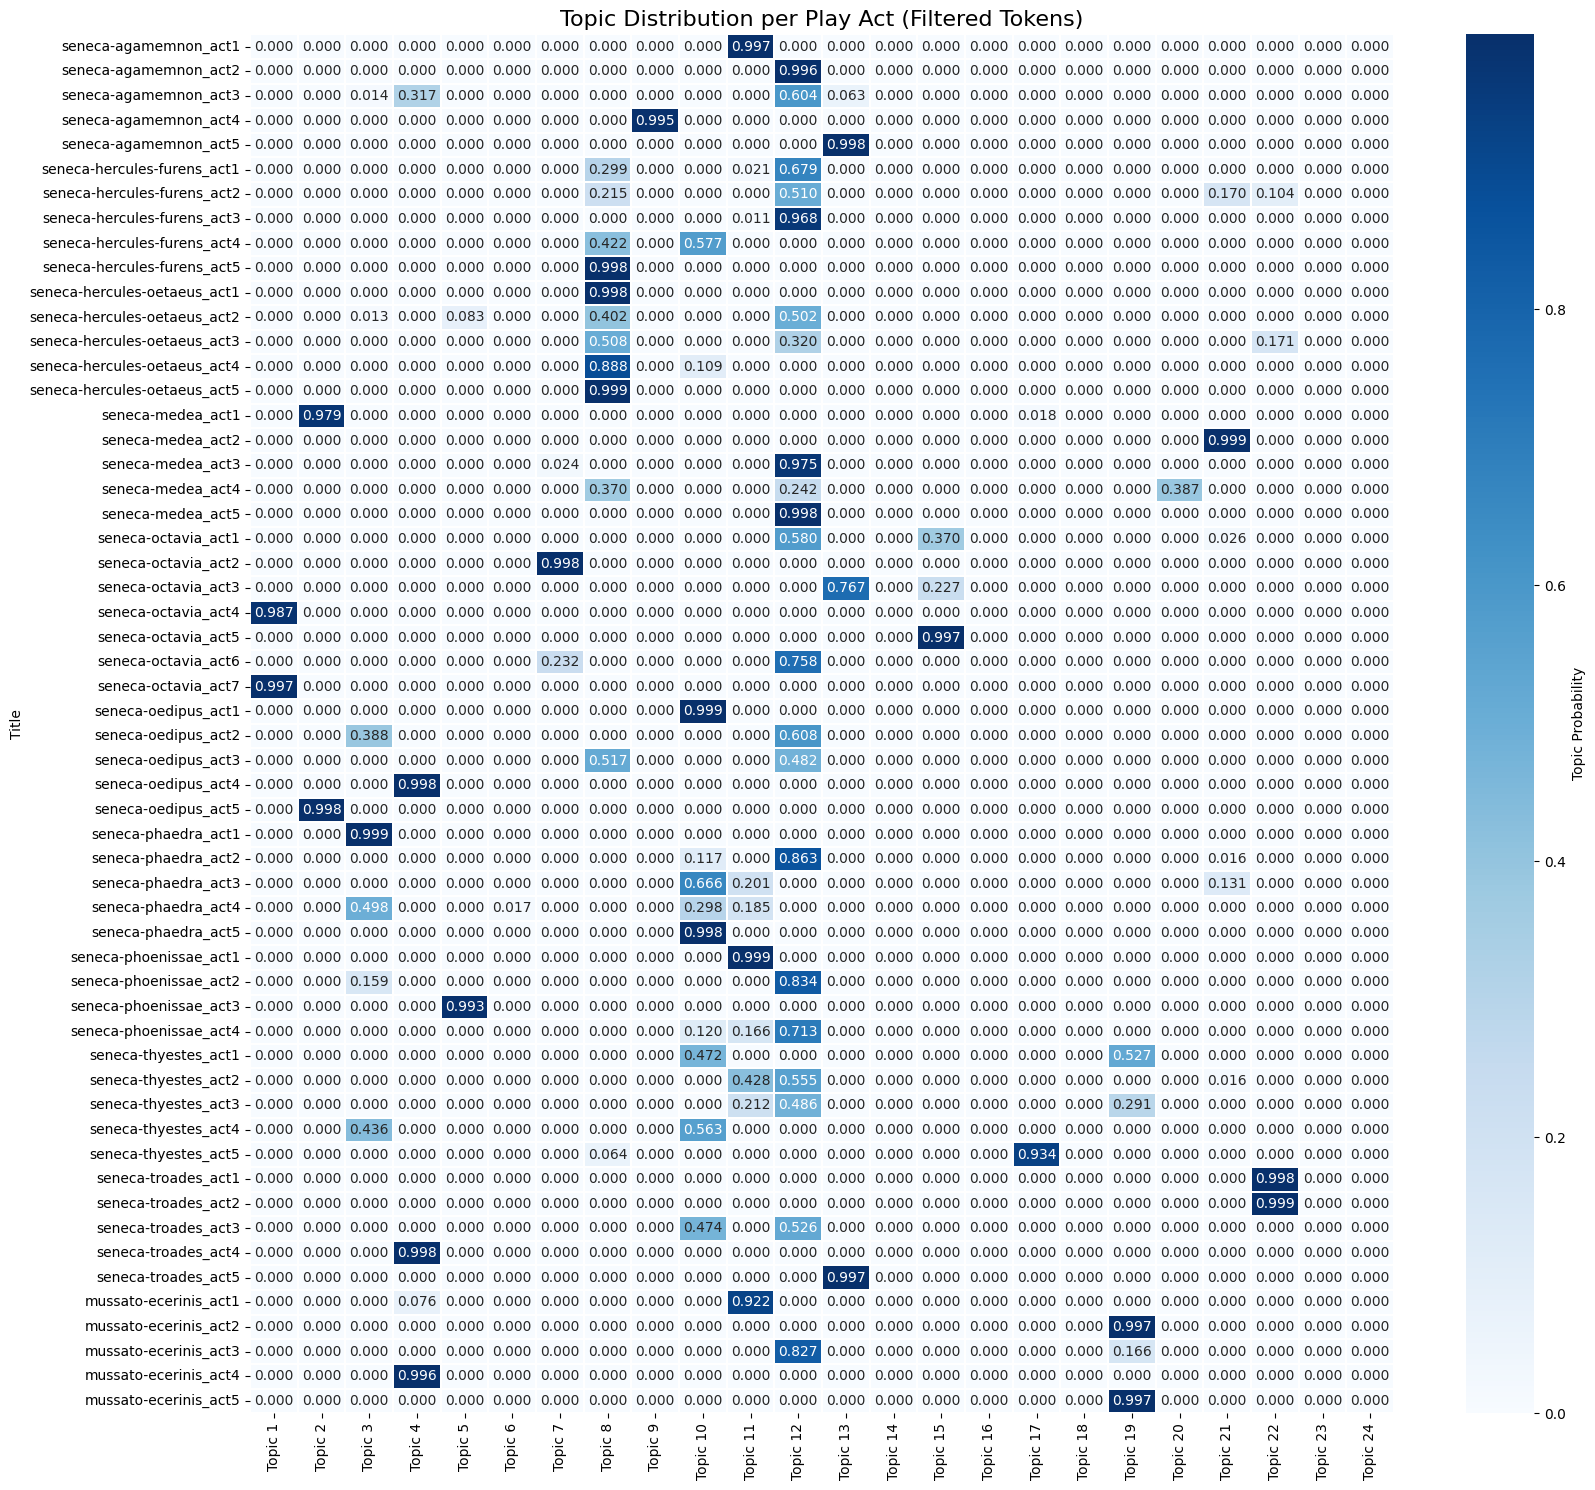

In [58]:
plt.figure(figsize=(17, 15))
sns.heatmap(
    filt_df_topics.set_index("Title"),
    cmap="Blues",
    annot=True,
    fmt=".3f",                     # Show probabilities with 3 decimal places
    linewidths=0.3,                # Draw lines between cells
    linecolor='white',            # Use white gridlines
    cbar_kws={"label": "Topic Probability"}  # Label for the color bar
)
plt.title("Topic Distribution per Play Act (Filtered Tokens)", fontsize=16)
plt.tight_layout()
plt.savefig("../figures/acts_filtered_topics_heatmap.png", dpi=300)
plt.show()